In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error
from utils.utils import sum_channels_parallel
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

sns.set_theme()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Unfiltered proton data

In [3]:
data_1 = pd.read_pickle('../data/data_proton_photonsum_proton_1_2312.pkl')
data_5 = pd.read_pickle('../data/data_photonsum_proton_5_2312.pkl')
data_18 = pd.read_pickle('../data/data_photonsum_proton_18_2312.pkl')

In [4]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_1_2312.pkl')
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'group_number_proton'], inplace=True)
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond_1 = scaler.fit_transform(data_cond)

data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_5_2312.pkl')
data_cond.drop(columns=['proton_photon_sum', 'std_proton'], inplace=True)
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond_5 = scaler.fit_transform(data_cond)

data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_18_2312.pkl')
data_cond.drop(columns=['proton_photon_sum', 'std'], inplace=True)
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond_18 = scaler.fit_transform(data_cond)

#### Preprocess data

In [5]:
data_1 = np.log(data_1+1)
data_1 = np.float32(data_1)

data_5 = np.log(data_5+1)
data_5 = np.float32(data_5)

data_18 = np.log(data_18+1)
data_18 = np.float32(data_18)

In [6]:
_, x_test_1, _, y_test_1 = train_test_split(data_1, data_cond_1, test_size=0.2, shuffle=False)
print(x_test_1.shape)

_, x_test_5, _, y_test_5 = train_test_split(data_5, data_cond_5, test_size=0.2, shuffle=False)
print(x_test_5.shape)

_, x_test_18, _, y_test_18 = train_test_split(data_18, data_cond_18, test_size=0.2, shuffle=False)
print(x_test_18.shape)

(68846, 56, 30)
(37220, 56, 30)
(17296, 56, 30)


## VAE

In [7]:
vae_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_vae_175.h5",
    compile=False)

vae_5 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\5_proton\\gen_vae_276.h5",
    compile=False)

vae_18 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_vae_320.h5",
    compile=False)

### Function for calculating sum of channels

In [11]:
from utils.utils import sum_channels_parallel

### Calculate channels for original simulation test data

In [13]:
org_1 = np.exp(x_test_1)-1
ch_org_1 = np.array(org_1).reshape(-1, 56, 30)
ch_org_1 = pd.DataFrame(sum_channels_parallel(ch_org_1)).values
del org_1

org_5 = np.exp(x_test_5)-1
ch_org_5 = np.array(org_5).reshape(-1, 56, 30)
ch_org_5 = pd.DataFrame(sum_channels_parallel(ch_org_5)).values
del org_5

org_18 = np.exp(x_test_18)-1
ch_org_18 = np.array(org_18).reshape(-1, 56, 30)
ch_org_18 = pd.DataFrame(sum_channels_parallel(ch_org_18)).values
del org_18

## Plot samples

Incomplete. It is hard to plot samples fro 3 different subsets of data.
so I would have 3 rows with original data as well

In [92]:
def generate_and_save_images(test_input, SAMPLES_IDXs, k):


    seed = tf.random.normal([len(SAMPLES_IDXs), noise_dim])
    seed_cond = y_test_1[SAMPLES_IDXs]
    test_input_1 = [seed, seed_cond], SAMPLES_IDXs

    # produce predictions
    predictions_vae_1 = vae_1(test_input, training=False)
    predictions_vae_5 = vae_5(test_input, training=False)
    predictions_vae_18 = vae_18(test_input, training=False)

    fig, axs = plt.subplots(6, 7, figsize=(12, 16))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, 42):
        if i < 7:
            # Real Neutron
            title_model = "True ZP"
            row = 0
            x = x_test[SAMPLES_IDXs][i % 7].reshape(56, 30)
        elif i >= 7 and i < 14:
            # VAE model
            title_model = "VAE"
            row = 1
            x = predictions_vae[i % 7].numpy().reshape(56, 30)
        elif i >= 14 and i < 21:
            title_model = "GAN"
            # GAN model
            row = 2
            x = predictions_gan[i % 7].numpy().reshape(56, 30)
        elif i >= 21 and i < 28:
            # SDI-GAN model
            title_model = "SDI-GAN"
            row = 3
            x = predictions_sdigan[i % 7].numpy().reshape(56, 30)
        elif i >= 28 and i < 35:
            title_model = "SDI-GAN + reg"
            # SDIN-GAN model
            row = 4
            x = predictions_sdigan_reg[i % 7].numpy().reshape(56, 30)
        else:
            title_model = "SDI-GAN + reg + aux"
            # SDIN-GAN model
            row = 5
            x = predictions_sdigan_reg_aux[i % 7].numpy().reshape(56, 30)

        axs[row, 5].set_title(title_model, fontsize=15)
        im = axs[row, i % 7].imshow(x, cmap='gnuplot')
        axs[row, i % 7].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 7 == 6:
            fig.colorbar(im, ax=axs[i // 7, :])

    # plt.tight_layout()
    plt.savefig(f"Thesis images/generating_best_images/{'_'.join([str(x) for x in SAMPLES_IDXs])}_{k}.png", dpi=300)
    plt.close()

## Histogram plots

In [14]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

541/541 [==============================] - 4s 7ms/step


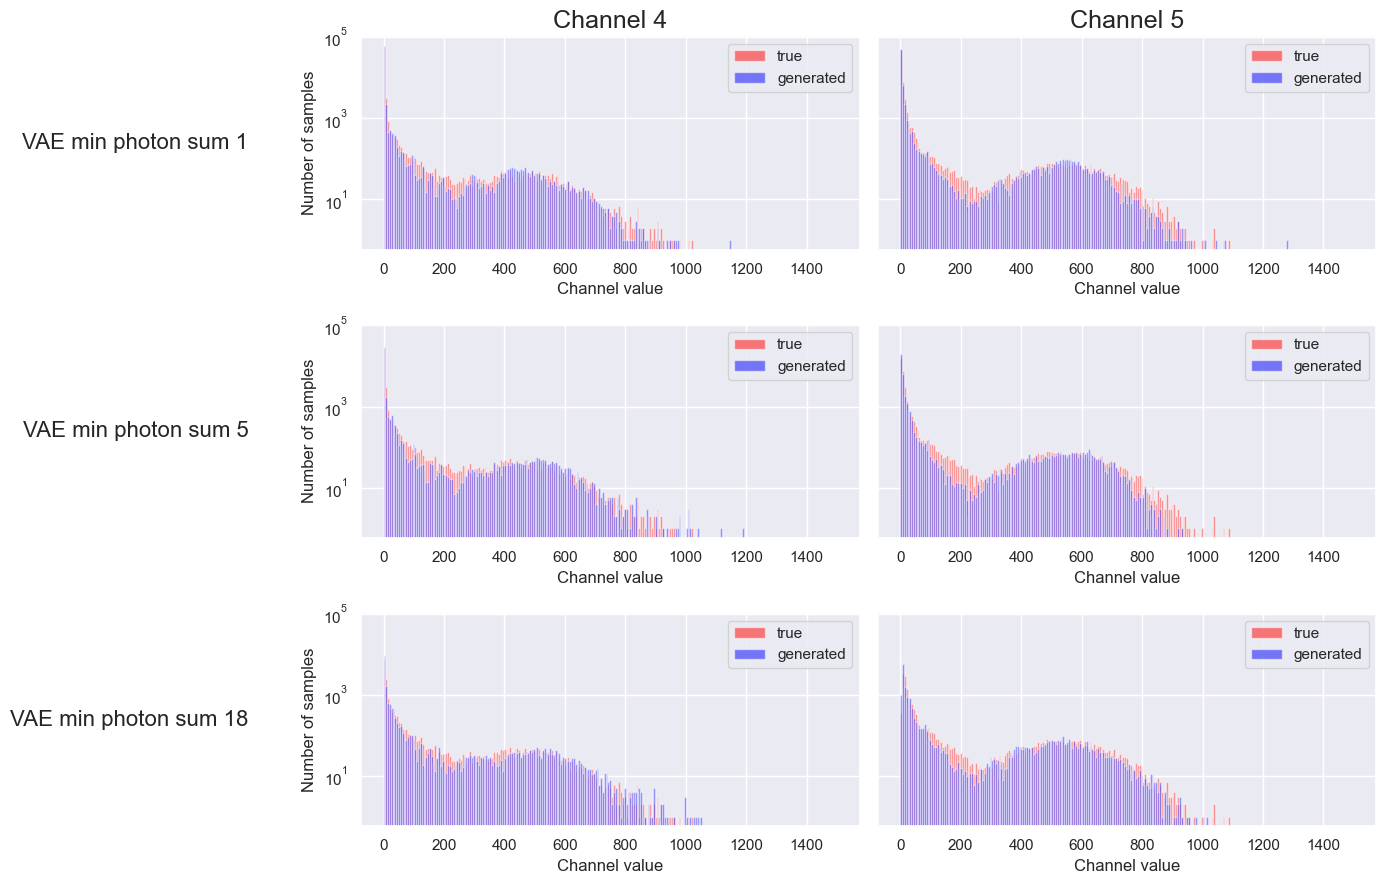

In [15]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_vae_1 = get_channels_dist_from_proton_model(vae_1, z_1, y_test_1, scale)
models_dist_vae_5 = get_channels_dist_from_proton_model(vae_5, z_5, y_test_5, scale)
models_dist_vae_18 = get_channels_dist_from_proton_model(vae_18, z_18, y_test_18, scale)


fig, axis = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for (i, model_data), ch_data in zip(enumerate([models_dist_vae_1, models_dist_vae_5, models_dist_vae_18]), [ch_org_1, ch_org_5, ch_org_18]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['VAE min photon sum 1', 'VAE min photon sum 5', 'VAE min photon sum 18']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_vae_levels.png", dpi=300)
plt.show()

## GAN

In [16]:
gan_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_gan_46.h5",
    compile=False)

gan_5 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\5_proton\\gen_gan_84.h5",
    compile=False)

gan_18 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_gan_224.h5",
    compile=False)

## Histogram plots

In [17]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

541/541 [==============================] - 16s 30ms/step


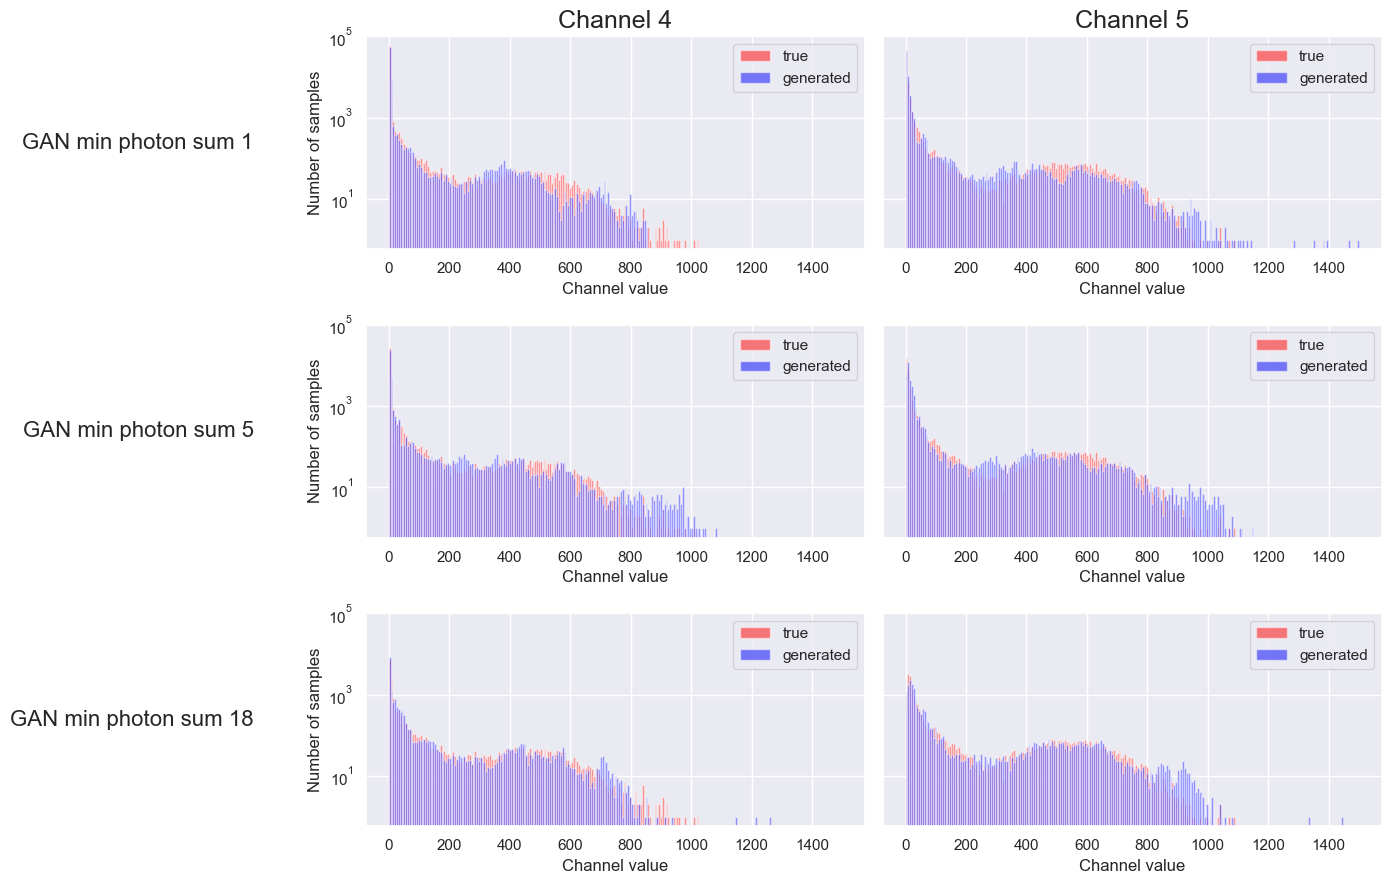

In [18]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_gan_1 = get_channels_dist_from_proton_model(gan_1, z_1, y_test_1, scale)
models_dist_gan_5 = get_channels_dist_from_proton_model(gan_5, z_5, y_test_5, scale)
models_dist_gan_18 = get_channels_dist_from_proton_model(gan_18, z_18, y_test_18, scale)


fig, axis = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for (i, model_data), ch_data in zip(enumerate([models_dist_gan_1, models_dist_gan_5, models_dist_gan_18]), [ch_org_1, ch_org_5, ch_org_18]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['GAN min photon sum 1', 'GAN min photon sum 5', 'GAN min photon sum 18']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_gan_levels_2.png", dpi=300)
plt.show()

## SDI-GAN

In [19]:
sdi_gan_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sdi-gan_51.h5",
    compile=False)

sdi_gan_5 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\5_proton\\gen_sdi-gan_126.h5",
    compile=False)

sdi_gan_18 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_sdi-gan_107.h5",
    compile=False)

## Histogram plots

In [20]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

541/541 [==============================] - 16s 29ms/step


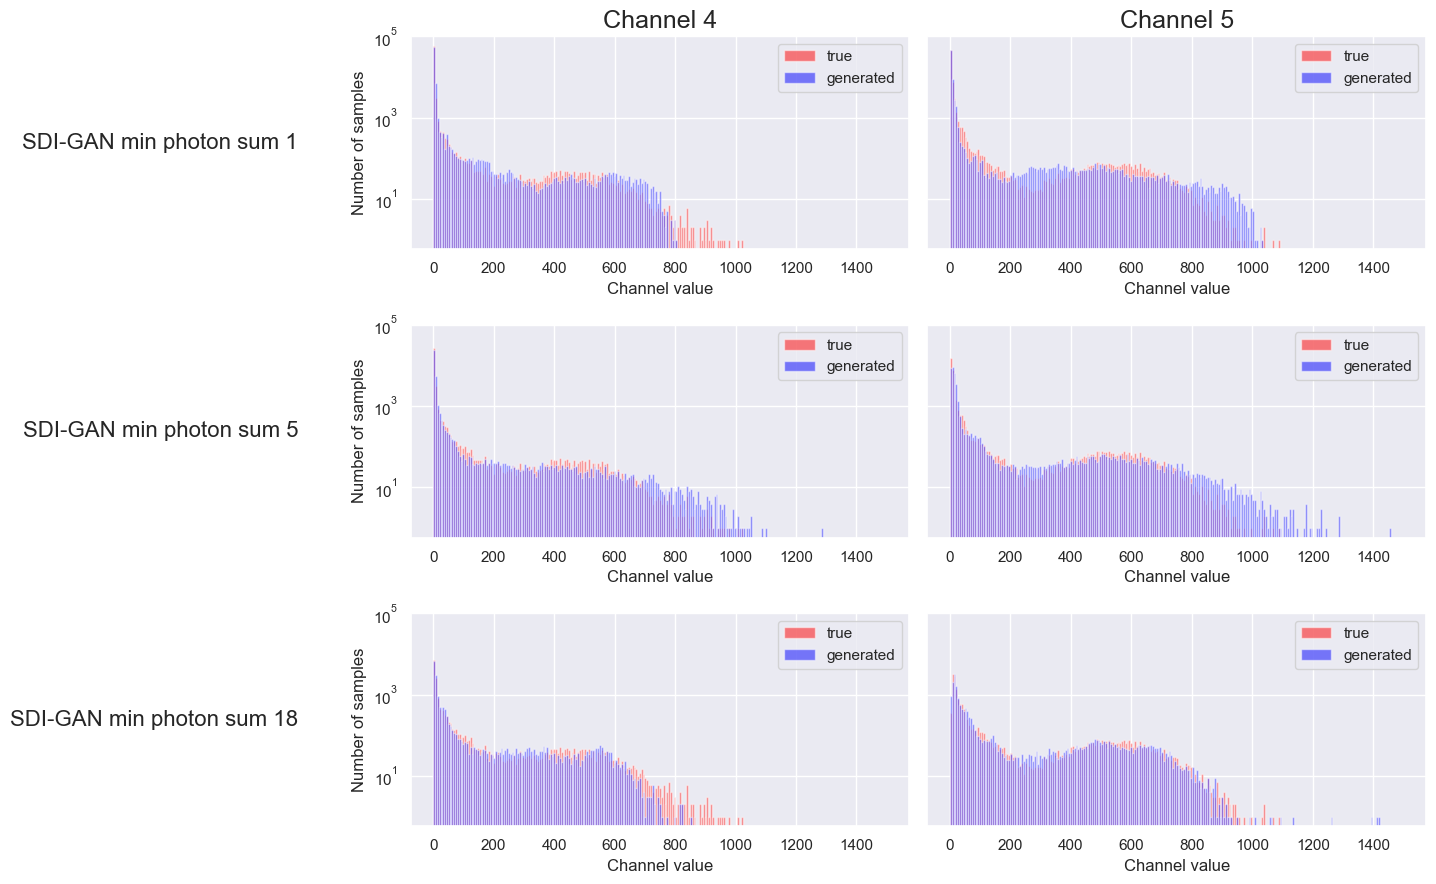

In [21]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdi_gan_1 = get_channels_dist_from_proton_model(sdi_gan_1, z_1, y_test_1, scale)
models_dist_sdi_gan_5 = get_channels_dist_from_proton_model(sdi_gan_5, z_5, y_test_5, scale)
models_dist_sdi_gan_18 = get_channels_dist_from_proton_model(sdi_gan_18, z_18, y_test_18, scale)


fig, axis = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for (i, model_data), ch_data in zip(enumerate([models_dist_sdi_gan_1, models_dist_sdi_gan_5, models_dist_sdi_gan_18]), [ch_org_1, ch_org_5, ch_org_18]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['SDI-GAN min photon sum 1', 'SDI-GAN min photon sum 5', 'SDI-GAN min photon sum 18']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_sdi_gan_levels.png", dpi=300)
plt.show()

## SDI-GAN + reg

In [22]:
sin_gan_reg_aux_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sin-gan_101.h5",
    compile=False)

sin_gan_reg_aux_5 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\5_proton\\gen_sin-gan_45.h5",
    compile=False)

sin_gan_reg_aux_18 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_sin-gan_113.h5",
    compile=False)

## Histogram plots

In [23]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

541/541 [==============================] - 16s 29ms/step


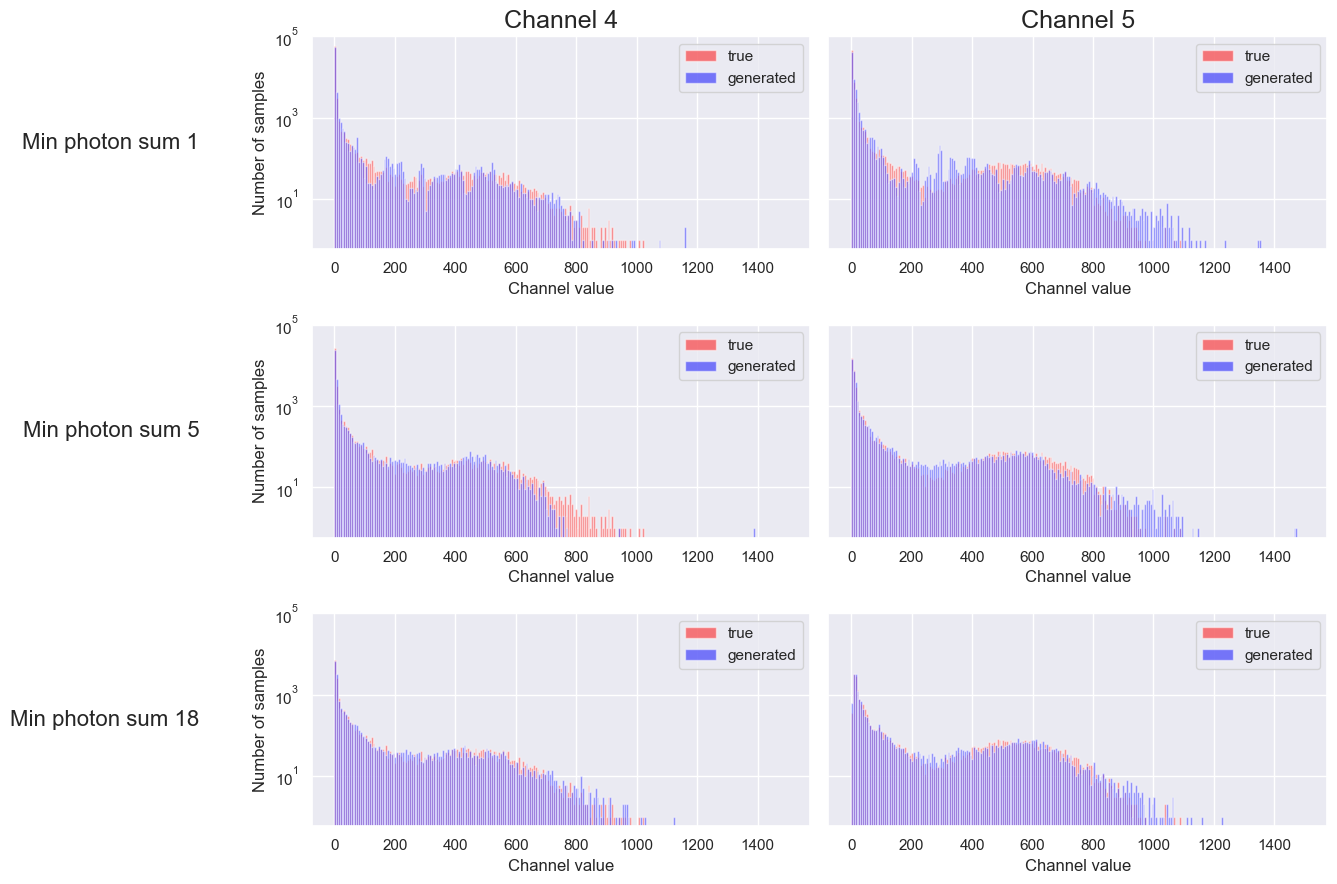

In [24]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sin_gan_reg_aux_1 = get_channels_dist_from_proton_model(sin_gan_reg_aux_1, z_1, y_test_1, scale)
models_dist_sin_gan_reg_aux_5 = get_channels_dist_from_proton_model(sin_gan_reg_aux_5, z_5, y_test_5, scale)
models_dist_sin_gan_reg_aux_18 = get_channels_dist_from_proton_model(sin_gan_reg_aux_18, z_18, y_test_18, scale)


fig, axis = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for (i, model_data), ch_data in zip(enumerate([models_dist_sin_gan_reg_aux_1, models_dist_sin_gan_reg_aux_5, models_dist_sin_gan_reg_aux_18]), [ch_org_1, ch_org_5, ch_org_18]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['Min photon sum 1', 'Min photon sum 5', 'Min photon sum 18']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_sin_gan_reg_levels.png", dpi=300)
plt.show()

## SDI-GAN + reg + aux reg

In [25]:
sin_gan_reg_aux_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sin-gan-aux-reg-arch-2_215.h5",
    compile=False)

sin_gan_reg_aux_5 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\5_proton\\gen_sin-gan-aux-reg-arch-2_81.h5",
    compile=False)

sin_gan_reg_aux_18 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_sin-gan-aux-reg-arch-2_105.h5",
    compile=False)

## Histogram plots

In [26]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

541/541 [==============================] - 16s 29ms/step


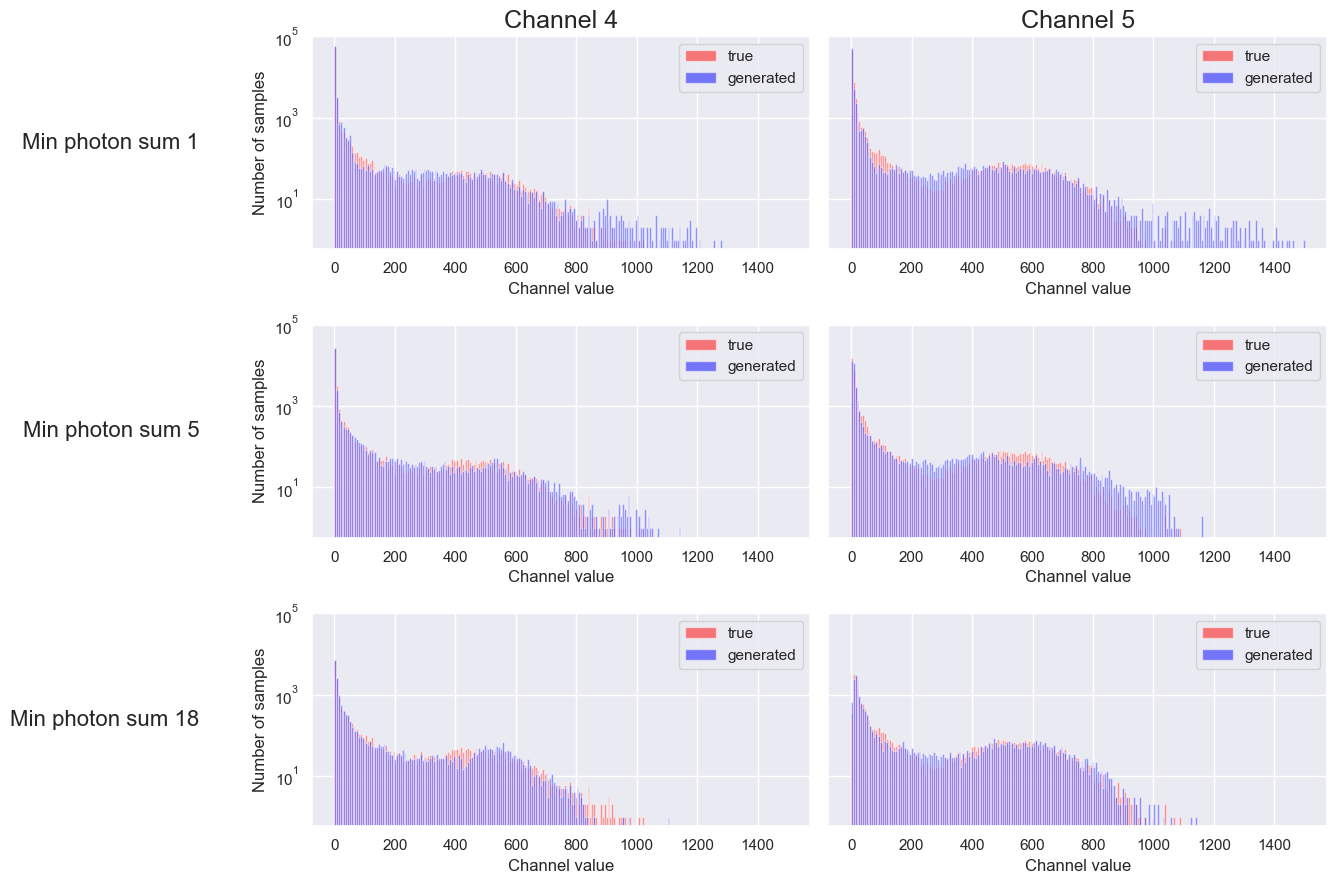

In [27]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sin_gan_reg_aux_1 = get_channels_dist_from_proton_model(sin_gan_reg_aux_1, z_1, y_test_1, scale)
models_dist_sin_gan_reg_aux_5 = get_channels_dist_from_proton_model(sin_gan_reg_aux_5, z_5, y_test_5, scale)
models_dist_sin_gan_reg_aux_18 = get_channels_dist_from_proton_model(sin_gan_reg_aux_18, z_18, y_test_18, scale)


fig, axis = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for (i, model_data), ch_data in zip(enumerate([models_dist_sin_gan_reg_aux_1, models_dist_sin_gan_reg_aux_5, models_dist_sin_gan_reg_aux_18]), [ch_org_1, ch_org_5, ch_org_18]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['Min photon sum 1', 'Min photon sum 5', 'Min photon sum 18']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_sin_gan_reg_aux_levels.png", dpi=300)
plt.show()

# ALL MODELS CHANNEL 4

In [40]:
z_1 = np.random.normal(0, noise_std, (x_test_1.shape[0], noise_dim))
z_5 = np.random.normal(0, noise_std, (x_test_5.shape[0], noise_dim))
z_18 = np.random.normal(0, noise_std, (x_test_18.shape[0], noise_dim))

# models_dist_vae_1 = get_channels_dist_from_proton_model(vae_1, z_1, y_test_1, scale)
# models_dist_gan_1 = get_channels_dist_from_proton_model(gan_1, z_1, y_test_1, scale)
# models_dist_sdi_gan_1 = get_channels_dist_from_proton_model(sdi_gan_1, z_1, y_test_1, scale)
models_dist_sin_gan_reg_1 = get_channels_dist_from_proton_model(sin_gan_reg_aux_1, z_1, y_test_1, scale)
# models_dist_sin_gan_reg_aux_1 = get_channels_dist_from_proton_model(sin_gan_reg_aux_1, z_1, y_test_1, scale)
# models_dist_vae_5 = get_channels_dist_from_proton_model(vae_5, z_5, y_test_5, scale)
# models_dist_gan_5 = get_channels_dist_from_proton_model(gan_5, z_5, y_test_5, scale)
# models_dist_sdi_gan_5 = get_channels_dist_from_proton_model(sdi_gan_5, z_5, y_test_5, scale)
models_dist_sin_gan_reg_5 = get_channels_dist_from_proton_model(sin_gan_reg_aux_5, z_5, y_test_5, scale)
# models_dist_sin_gan_reg_aux_5 = get_channels_dist_from_proton_model(sin_gan_reg_aux_5, z_5, y_test_5, scale)
# models_dist_vae_18 = get_channels_dist_from_proton_model(vae_18, z_18, y_test_18, scale)
# models_dist_gan_18 = get_channels_dist_from_proton_model(gan_18, z_18, y_test_18, scale)
# models_dist_sdi_gan_18 = get_channels_dist_from_proton_model(sdi_gan_18, z_18, y_test_18, scale)
models_dist_sin_gan_reg_18 = get_channels_dist_from_proton_model(sin_gan_reg_aux_18, z_18, y_test_18, scale)
# models_dist_sin_gan_reg_aux_18 = get_channels_dist_from_proton_model(sin_gan_reg_aux_18, z_18, y_test_18, scale)

541/541 [==============================] - 19s 34ms/step


In [ ]:
models_dist_vae_1,models_dist_vae_5, models_dist_vae_18,
models_dist_gan_1,models_dist_gan_5, models_dist_gan_18 ,
models_dist_sdi_gan_1,models_dist_sdi_gan_5, models_dist_sdi_gan_18,
models_dist_sin_gan_reg_1,models_dist_sin_gan_reg_5, models_dist_sin_gan_reg_18,
models_dist_sin_gan_reg_aux_1, models_dist_sin_gan_reg_aux_5, models_dist_sin_gan_reg_aux_18,

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


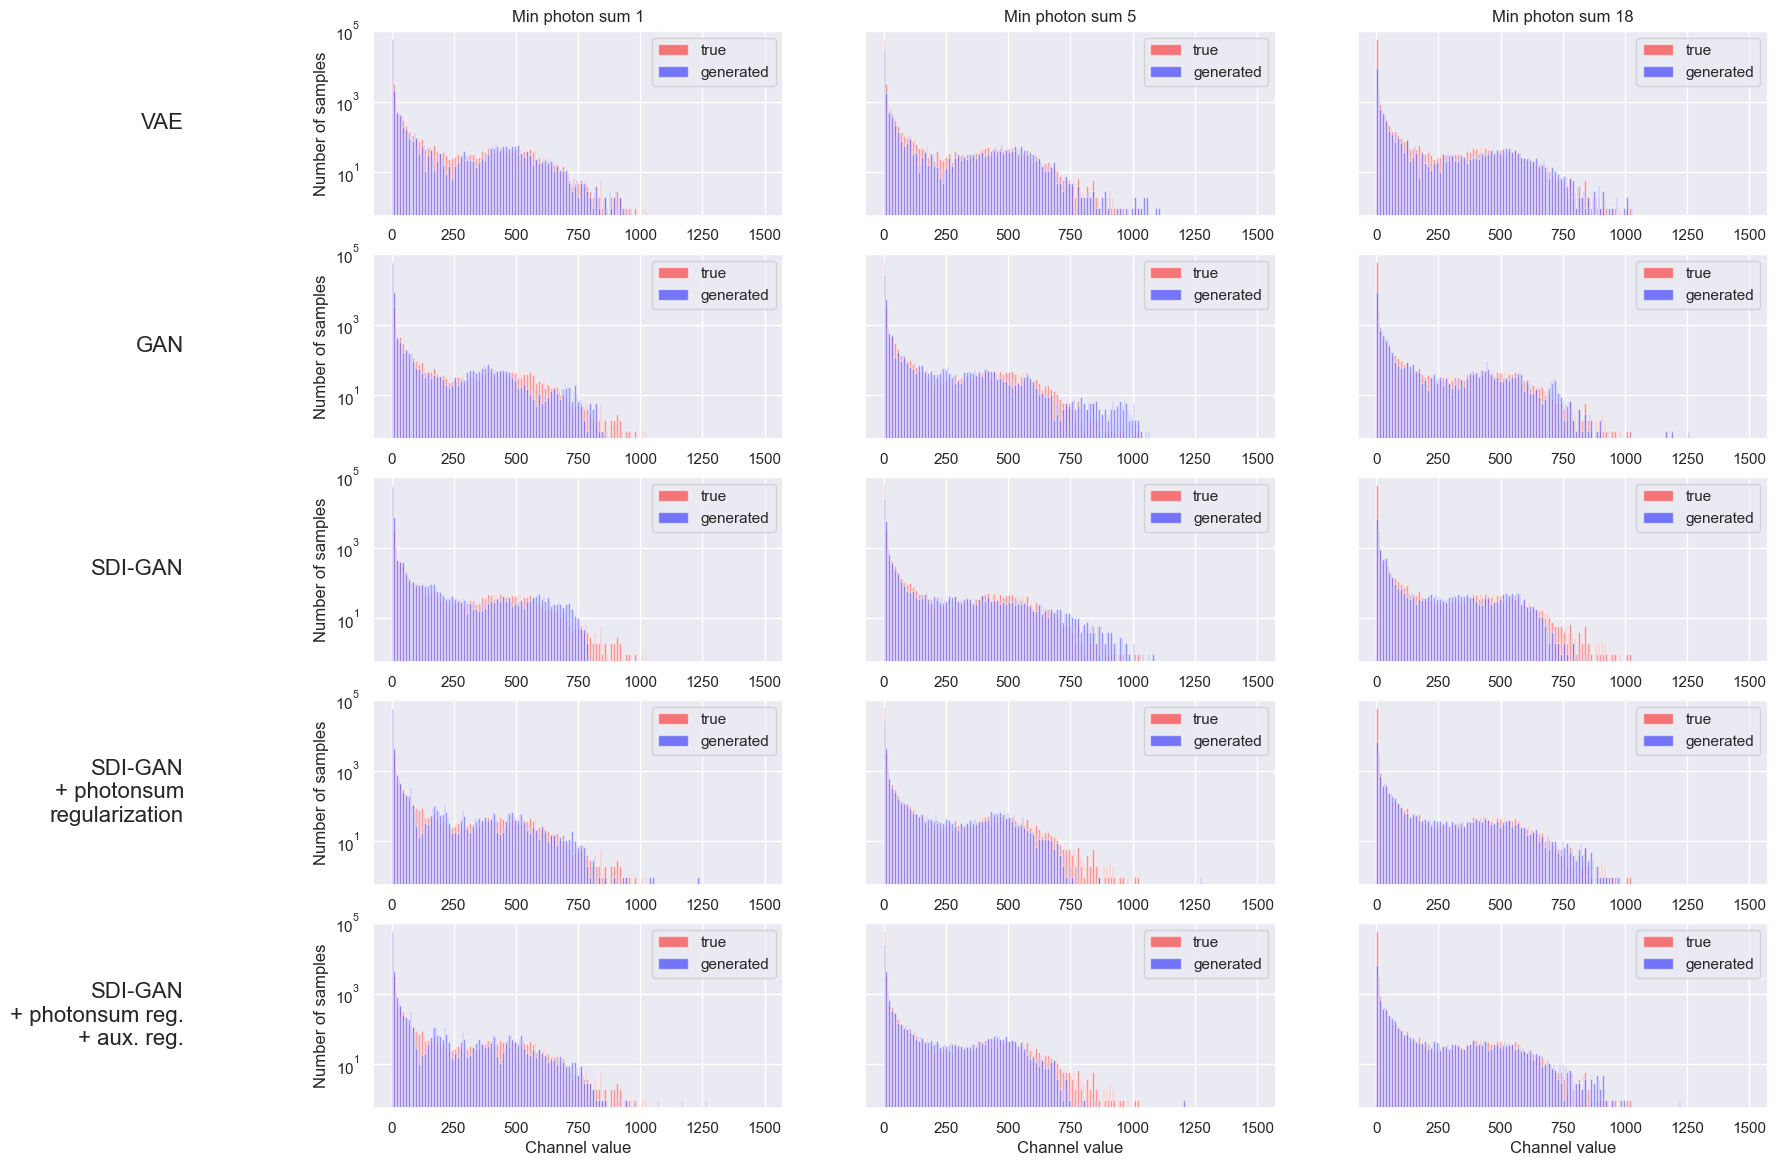

In [77]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5



fig, axis = plt.subplots(5, 3, figsize=(18, 14), sharex=False, sharey=True)

axis[0, 1].set_title('Channel 4', fontsize=18)

bins = np.linspace(0, 1500, 250)
row = 0
column = 0
for (i, model_data), ch_data in zip(enumerate([models_dist_vae_1,models_dist_vae_5, models_dist_vae_18,
                                               models_dist_gan_1,models_dist_gan_5, models_dist_gan_18 ,
                                               models_dist_sdi_gan_1,models_dist_sdi_gan_5, models_dist_sdi_gan_18,
                                               models_dist_sin_gan_reg_1,models_dist_sin_gan_reg_5, models_dist_sin_gan_reg_18,
                                               models_dist_sin_gan_reg_aux_1, models_dist_sin_gan_reg_aux_5, models_dist_sin_gan_reg_aux_18,]),
                                        [ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18]):
    column = column % 3
    #
    # if row == 1:
    #     break

    print(row, column)
    channel_data = model_data[:, 3]  # get channel 4 data
    axis[row][column].hist(ch_data[:,3], bins, alpha=0.5, label='true', color="red")
    axis[row][column].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
    axis[row][column].legend(loc='upper right')
    if column == 0:
        axis[row][column].set_ylabel('Number of samples')
    if row == 0:
        if column == 0:
            axis[row][column].set_title("Min photon sum 1")
        elif column == 1:
            axis[row][column].set_title("Min photon sum 5")
        elif column == 2:
            axis[row][column].set_title("Min photon sum 18")
    if row == 4:
        axis[row][column].set_xlabel('Channel value')
    axis[row][column].set_yscale('log')

    if column == 2:
        row += 1
    column += 1


row_titles = ['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization', 'SDI-GAN\n+ photonsum reg.\n+ aux. reg.']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

#     for j, channel_id in enumerate(channels_to_get):
#         channel_data = model_data[:, channel_id]
#         axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
#         axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
#         axis[i][j].legend(loc='upper right')
#         if j == 0:
#             axis[i][j].set_ylabel('Number of samples')
#         axis[i][j].set_xlabel('Channel value')
#         axis[i][j].set_yscale('log')
#
# fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])
#
# row_titles = ['VAE min photon sum 1', 'VAE min photon sum 5', 'VAE min photon sum 18']
# for ax, row in zip(axis[:,0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)
#
fig.savefig("Thesis images/histograms_4_levels.png", dpi=300)
# plt.show()

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


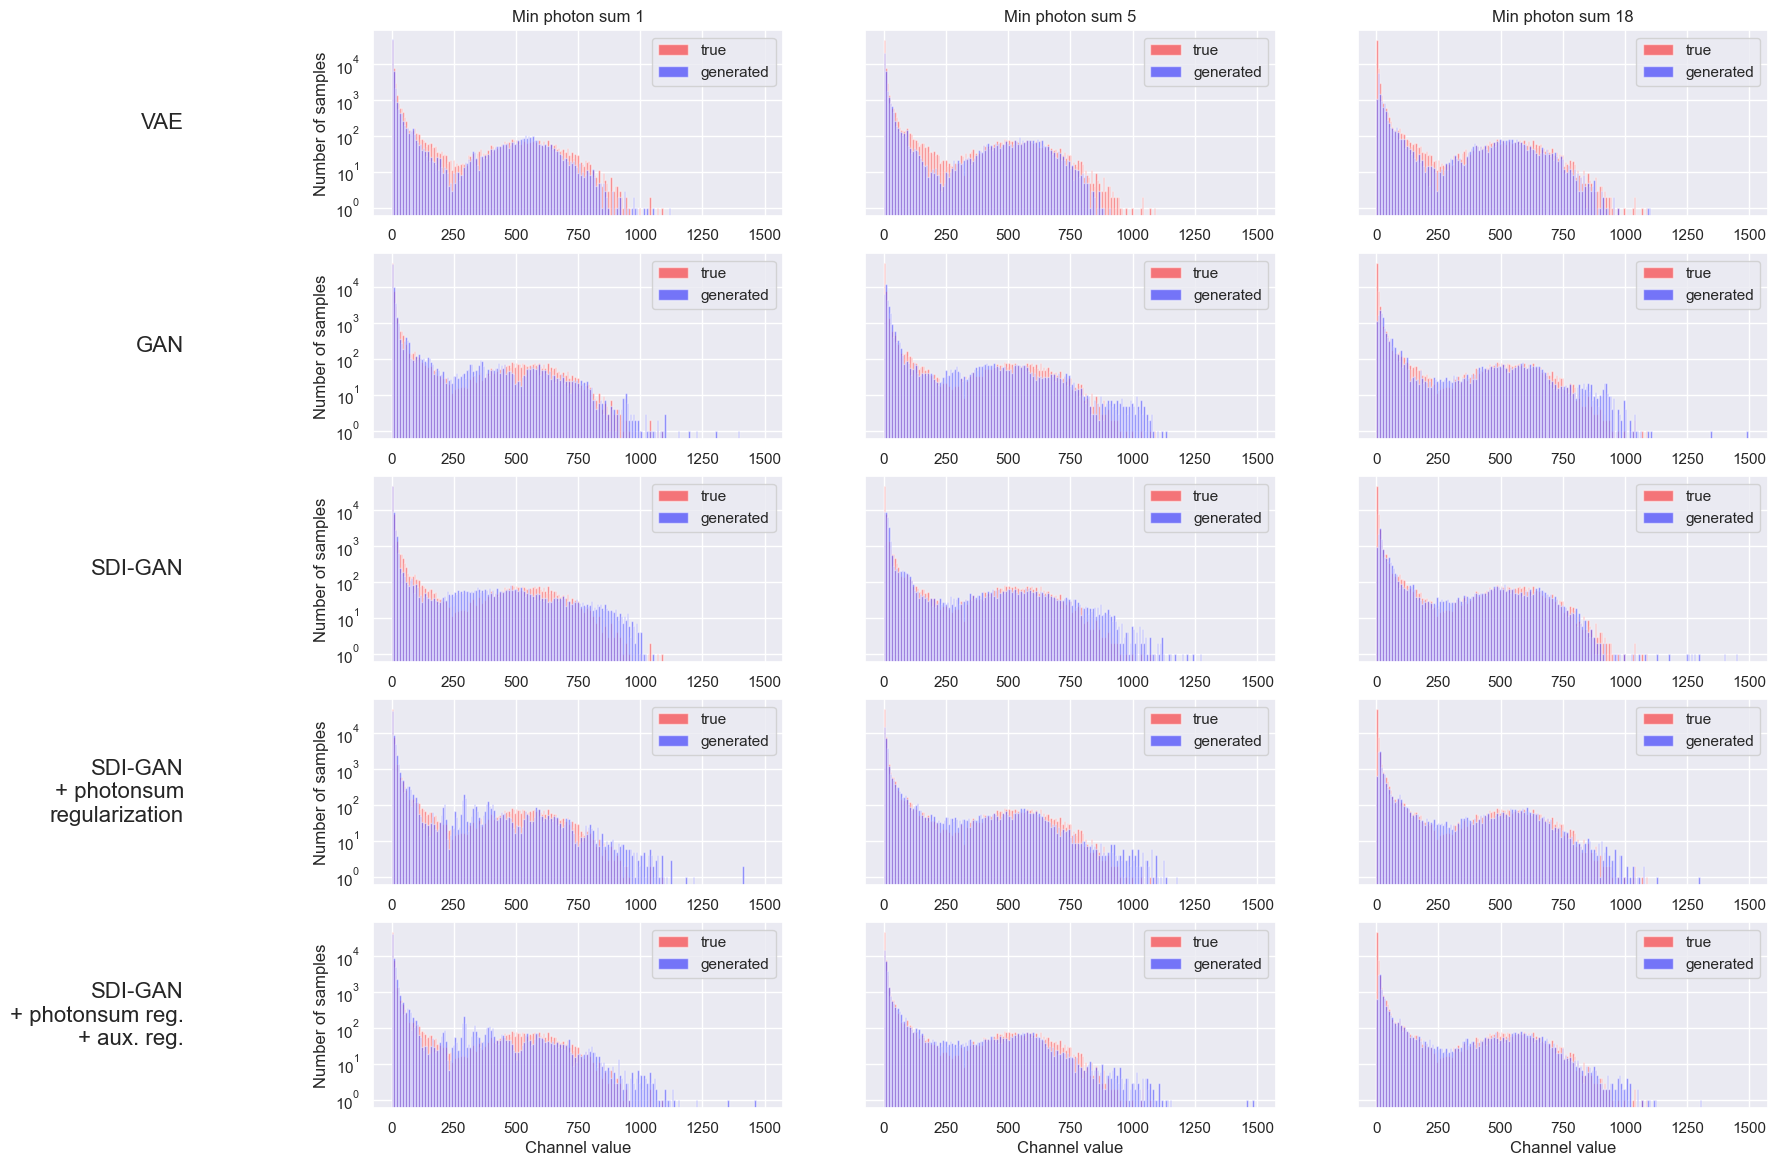

In [76]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5



fig, axis = plt.subplots(5, 3, figsize=(18, 14), sharex=False, sharey=True)

axis[0, 1].set_title('Channel 4', fontsize=18)

bins = np.linspace(0, 1500, 250)
row = 0
column = 0
for (i, model_data), ch_data in zip(enumerate([models_dist_vae_1,models_dist_vae_5, models_dist_vae_18,
                                               models_dist_gan_1,models_dist_gan_5, models_dist_gan_18 ,
                                               models_dist_sdi_gan_1,models_dist_sdi_gan_5, models_dist_sdi_gan_18,
                                               models_dist_sin_gan_reg_1,models_dist_sin_gan_reg_5, models_dist_sin_gan_reg_18,
                                               models_dist_sin_gan_reg_aux_1, models_dist_sin_gan_reg_aux_5, models_dist_sin_gan_reg_aux_18,]),
                                        [ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18,
                                        ch_org_1, ch_org_5, ch_org_18]):
    column = column % 3
    #
    # if row == 1:
    #     break

    print(row, column)
    channel_data = model_data[:, 4]  # get channel 5 data
    axis[row][column].hist(ch_data[:, 4], bins, alpha=0.5, label='true', color="red")
    axis[row][column].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
    axis[row][column].legend(loc='upper right')
    if column == 0:
        axis[row][column].set_ylabel('Number of samples')
    if row == 0:
        if column == 0:
            axis[row][column].set_title("Min photon sum 1")
        elif column == 1:
            axis[row][column].set_title("Min photon sum 5")
        elif column == 2:
            axis[row][column].set_title("Min photon sum 18")
    if row == 4:
        axis[row][column].set_xlabel('Channel value')
    axis[row][column].set_yscale('log')

    if column == 2:
        row += 1
    column += 1


row_titles = ['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization', 'SDI-GAN\n+ photonsum reg.\n+ aux. reg.']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

#     for j, channel_id in enumerate(channels_to_get):
#         channel_data = model_data[:, channel_id]
#         axis[i][j].hist(ch_data[:,channel_id], bins, alpha=0.5, label='true', color="red")
#         axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
#         axis[i][j].legend(loc='upper right')
#         if j == 0:
#             axis[i][j].set_ylabel('Number of samples')
#         axis[i][j].set_xlabel('Channel value')
#         axis[i][j].set_yscale('log')
#
# fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])
#
# row_titles = ['VAE min photon sum 1', 'VAE min photon sum 5', 'VAE min photon sum 18']
# for ax, row in zip(axis[:,0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)
#
fig.savefig("Thesis images/histograms_5_levels.png", dpi=300)
# plt.show()